<a href="https://colab.research.google.com/github/nasiksami/Deep-Learning/blob/main/YOLO_V3_for_Multiple_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Mounted at /content/drive
Note: using Google CoLab


In [7]:
import sys
sys.path.extend(['/content/drive/My Drive/projects/t81_558_dlearning/yolo'])

In [21]:
!git clone https://github.com/thtrieu/darkflow.git

fatal: destination path 'darkflow' already exists and is not an empty directory.


In [22]:
!pip install ./darkflow/

Processing ./darkflow
  Created wheel for darkflow: filename=darkflow-1.0.0-cp36-cp36m-linux_x86_64.whl size=816411 sha256=da12b17f23d0c04fefc08ae5ede45ce06c74362945ad53fe166f8fa6725b45e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1j3aw9v/wheels/2f/3a/c5/e84e79d73d5a73aa1b5129a66a40947d9d77a32ebed501e431
Successfully built darkflow
  Found existing installation: darkflow 1.0.0
    Uninstalling darkflow-1.0.0:
      Successfully uninstalled darkflow-1.0.0


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!mkdir -p /content/drive/ My\ Drive/projects
!mkdir -p /content/drive/ My\ Drive/projects/yolo
!mkdir -p /content/drive/ My\ Drive/projects/yolo/bin
!mkdir -p /content/drive/ My\ Drive/projects/yolo/cfg

In [24]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/projects/t81_558_dlearning/'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/convert.py")

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/data/coco.names")
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


In [25]:
import sys
!{sys.executable} "{filename_convert_script}" --weights \
    "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-11-18 16:55:34.899743: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-18 16:55:36.565365: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-18 16:55:36.613058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-18 16:55:36.613857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-11-18 16:55:36.613906: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-18 16:55:36.838657: I tensorflow/stream_executor/platform/defa

In [26]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, \
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [27]:

# This example does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


In [30]:
url = "https://thubajvc.files.wordpress.com/2014/02/fridge.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

In [31]:
# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.70


In [32]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	refrigerator, 0.9961421489715576, [0.01838169 0.06393528 0.888996   0.9690759 ]


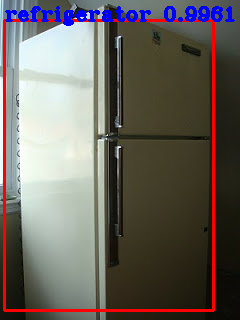

In [33]:

# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

In [36]:

url = "https://www.howtogeek.com/wp-content/uploads/2019/08/img_5d603e1a30d8f.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:00.13


In [37]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	cell phone, 0.7132918834686279, [0.6743723  0.5489711  0.7666117  0.66722757]
	cell phone, 0.6887581944465637, [0.48526242 0.45770627 0.61397076 0.73455304]


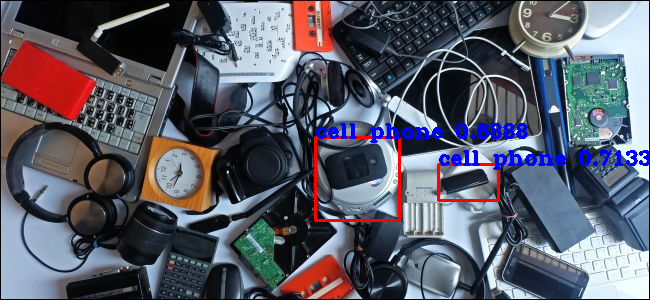

In [38]:

# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

Pretty bad prediction than the other one


In [39]:

url = "https://www.batteriesinaflash.com/blog/wp-content/uploads/2014/05/old-electronics.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:00.13


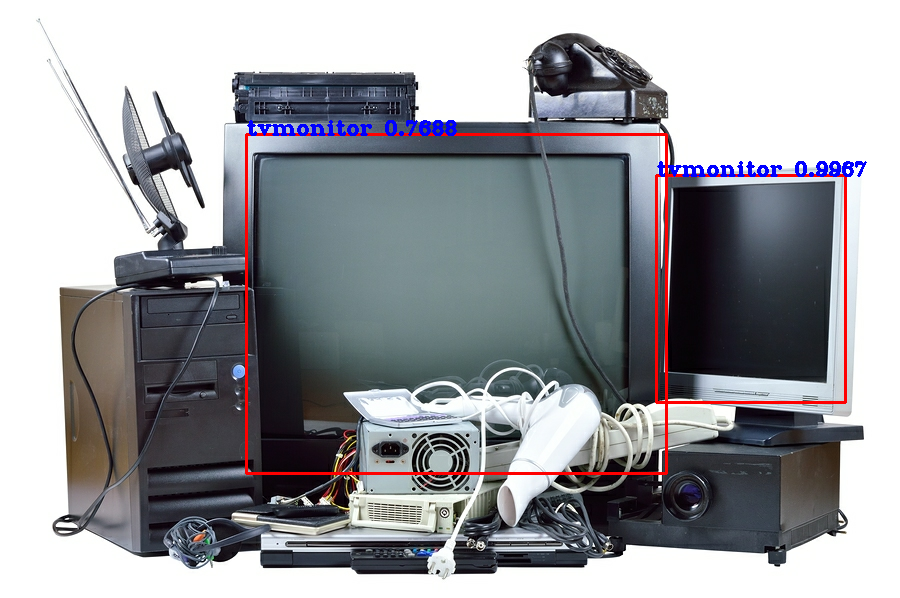

In [40]:

# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image